In [1]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint


In [2]:
rc = commons.rc

In [3]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [4]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                          'SVR-linear'   : 'SVR - linear',
                          'SVR-poly'     : 'SVR - poly',
                          'SVR-rbf'      : 'SVR - rbf',
                          'SVR-sigmoid'  : 'SVR - sigmoid',
                          'Lasso'        : 'Lasso',
                          'LassoCV'      : 'Lasso CV',
                          'Ridge'        : 'Ridge',
                          'RidgeCV'      : 'Ridge CV',
                          'ElasticNet'   : 'Elastic Net',
                          'ElasticNetCV' : 'Elastic Net CV',
                          'BayesianRidge': 'Bayesian Ridge',
                          'ARD'          : 'Automatic Relevance Determination',
                          'SGD'          : 'Stochastic Gradient Descent',
                          'PA'           : 'Passive Aggressive',
                          'Huber'        : 'Huber',
                          'TheilSen'     : 'Theil Sen'}
    #
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [5]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [6]:
def save_plot(obj, name, loc="./fig/"):
    obj.savefig(f"{loc}{name}.pdf", transparent=True)
    obj.savefig(f"{loc}{name}.png", transparent=True)

# Get the recSchedTimes data

In [7]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [ ]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

Output()

In [9]:
wfNames = bigtable.wfName.unique()

In [10]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [11]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [12]:
rc.print(bigtable.cluster.unique())
rc.print(len(bigtable.cluster.unique()))

['(166, 171, 173, 175, 178, 179, 180, 182, 182, 183, 185, 191, 192, 193)'
 '(167, 168, 168, 169, 169, 169, 173, 175, 175, 184, 186, 186, 188, 189, 190, 191, 192, 192)'
 '(168, 171, 176, 178, 180, 181, 182, 182, 184, 184, 186, 187)' ...
 '(165, 165, 170, 171, 171, 171, 172, 175, 179, 179, 180, 180, 181, 184, 191, 191, 193)'
 '(172, 172, 175, 183, 184, 185, 186, 186, 188, 188, 189, 190, 192, 192, 192)'
 '(178, 181, 181, 182, 183, 184, 185, 185, 187, 190)']

10000

In [13]:
tmp = bigtable[bigtable.schedCat != "random"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [14]:
def getRegModelMethodScores(fileLoc: Path, table):
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = bigtable[bigtable.schedCat != "random"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        del tmp
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        tol = 1
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    if abs(subtable.loc[rM, meth] - minimumTime) <= tol:
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + 1
                prog.advance(cvwfProg)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

In [15]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [16]:
pprint(regModelMethodScores)

{
│   ('4 / Passive Aggressive', 'recommenderV1'): 4786,
│   ('4 / Passive Aggressive', 'recommenderV1H1'): 4596,
│   ('4 / Passive Aggressive', 'recommenderV1H2'): 4596,
│   ('4 / Passive Aggressive', 'recommenderV1H3'): 4877,
│   ('4 / Passive Aggressive', 'recommenderV2H1'): 3024,
│   ('4 / Passive Aggressive', 'recommenderV2H2'): 3024,
│   ('4 / Passive Aggressive', 'recommenderV2H3'): 2928,
│   ('3 / Elastic Net', 'recommenderV1'): 5347,
│   ('3 / Elastic Net', 'recommenderV1H1'): 4954,
│   ('3 / Elastic Net', 'recommenderV1H2'): 4954,
│   ('3 / Elastic Net', 'recommenderV1H3'): 4851,
│   ('3 / Elastic Net', 'recommenderV2H1'): 4000,
│   ('3 / Elastic Net', 'recommenderV2H2'): 4000,
│   ('3 / Elastic Net', 'recommenderV2H3'): 3851,
│   ('3 / Ridge', 'recommenderV1'): 9628,
│   ('3 / Ridge', 'recommenderV1H1'): 10563,
│   ('3 / Ridge', 'recommenderV1H2'): 10563,
│   ('3 / Ridge', 'recommenderV1H3'): 11010,
│   ('3 / Ridge', 'recommenderV2H1'): 6824,
│   ('3 / Ridge', 'recommenderV2H2'): 6824,
│   ('3 / Ridge', 'recommenderV2H3'): 6643,
│   ('5 / Ordinary Least Squares', 'recommenderV1'): 25731,
│   ('5 / Ordinary Least Squares', 'recommenderV1H1'): 27353,
│   ('5 / Ordinary Least Squares', 'recommenderV1H2'): 27353,
│   ('5 / Ordinary Least Squares', 'recommenderV1H3'): 28508,
│   ('5 / Ordinary Least Squares', 'recommenderV2H1'): 9903,
│   ('5 / Ordinary Least Squares', 'recommenderV2H2'): 9903,
│   ('5 / Ordinary Least Squares', 'recommenderV2H3'): 9654,
│   ('2 / Ridge CV', 'recommenderV1'): 5328,
│   ('2 / Ridge CV', 'recommenderV1H1'): 5502,
│   ('2 / Ridge CV', 'recommenderV1H2'): 5502,
│   ('2 / Ridge CV', 'recommenderV1H3'): 5439,
│   ('2 / Ridge CV', 'recommenderV2H1'): 5668,
│   ('2 / Ridge CV', 'recommenderV2H2'): 5668,
│   ('2 / Ridge CV', 'recommenderV2H3'): 5445,
│   ('1 / Elastic Net', 'recommenderV1'): 3789,
│   ('1 / Elastic Net', 'recommenderV1H1'): 4030,
│   ('1 / Elastic Net', 'recommenderV1H2'): 4030,
│   ('1 / Elastic Net', 'recommenderV1H3'): 4232,
│   ('1 / Elastic Net', 'recommenderV2'): 2613,
│   ('1 / Elastic Net', 'recommenderV2H1'): 2895,
│   ('1 / Elastic Net', 'recommenderV2H2'): 2895,
│   ('1 / Elastic Net', 'recommenderV2H3'): 2833,
│   ('1 / Ordinary Least Squares', 'recommenderV1'): 5369,
│   ('1 / Ordinary Least Squares', 'recommenderV1H1'): 5422,
│   ('1 / Ordinary Least Squares', 'recommenderV1H2'): 5422,
│   ('1 / Ordinary Least Squares', 'recommenderV1H3'): 5116,
│   ('1 / Ordinary Least Squares', 'recommenderV2H1'): 5089,
│   ('1 / Ordinary Least Squares', 'recommenderV2H2'): 5089,
│   ('1 / Ordinary Least Squares', 'recommenderV2H3'): 4854,
│   ('1 / Lasso CV', 'recommenderV1'): 5346,
│   ('1 / Lasso CV', 'recommenderV1H1'): 5516,
│   ('1 / Lasso CV', 'recommenderV1H2'): 5516,
│   ('1 / Lasso CV', 'recommenderV1H3'): 5329,
│   ('1 / Lasso CV', 'recommenderV2H1'): 4961,
│   ('1 / Lasso CV', 'recommenderV2H2'): 4961,
│   ('1 / Lasso CV', 'recommenderV2H3'): 4766,
│   ('3 / SVR - linear', 'recommenderV1'): 5818,
│   ('3 / SVR - linear', 'recommenderV1H1'): 6311,
│   ('3 / SVR - linear', 'recommenderV1H2'): 6311,
│   ('3 / SVR - linear', 'recommenderV1H3'): 6909,
│   ('3 / SVR - linear', 'recommenderV2H1'): 5875,
│   ('3 / SVR - linear', 'recommenderV2H2'): 5875,
│   ('3 / SVR - linear', 'recommenderV2H3'): 5797,
│   ('3 / Elastic Net CV', 'recommenderV1'): 7031,
│   ('3 / Elastic Net CV', 'recommenderV1H1'): 6694,
│   ('3 / Elastic Net CV', 'recommenderV1H2'): 6694,
│   ('3 / Elastic Net CV', 'recommenderV1H3'): 6641,
│   ('3 / Elastic Net CV', 'recommenderV2H1'): 5512,
│   ('3 / Elastic Net CV', 'recommenderV2H2'): 5512,
│   ('3 / Elastic Net CV', 'recommenderV2H3'): 5272,
│   ('1 / SVR - linear', 'recommenderV1'): 4731,
│   ('1 / SVR - linear', 'recommenderV1H1'): 5343,
│   ('1 / SVR - linear', 'recommenderV1H2'): 5343,
│   ('1 / SVR - linear', 'recommenderV1H3'): 5141,
│   ('1 / SVR - linear', 'recommenderV2H1'): 4546,
│   ('1 / SVR - linear', 'recommenderV2H2'): 4546,
│   ('1 / SV

In [17]:
scoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    scoresDF.loc[rM, meth] = s

In [18]:
scoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
4 / Passive Aggressive,4786.0,4596.0,4596.0,4877.0,2888.0,3024.0,3024.0,2928.0
3 / Elastic Net,5347.0,4954.0,4954.0,4851.0,3742.0,4000.0,4000.0,3851.0
3 / Ridge,9628.0,10563.0,10563.0,11010.0,6874.0,6824.0,6824.0,6643.0
5 / Ordinary Least Squares,25731.0,27353.0,27353.0,28508.0,9615.0,9903.0,9903.0,9654.0
2 / Ridge CV,5328.0,5502.0,5502.0,5439.0,5277.0,5668.0,5668.0,5445.0
1 / Elastic Net,3789.0,4030.0,4030.0,4232.0,2613.0,2895.0,2895.0,2833.0
1 / Ordinary Least Squares,5369.0,5422.0,5422.0,5116.0,4605.0,5089.0,5089.0,4854.0
1 / Lasso CV,5346.0,5516.0,5516.0,5329.0,4467.0,4961.0,4961.0,4766.0
3 / SVR - linear,5818.0,6311.0,6311.0,6909.0,5492.0,5875.0,5875.0,5797.0
3 / Elastic Net CV,7031.0,6694.0,6694.0,6641.0,5087.0,5512.0,5512.0,5272.0


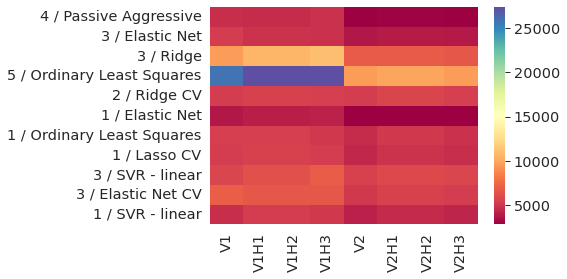

In [38]:
ax = sns.heatmap(scoresDF,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in scoresDF.columns],
                 robust=True)
plt.show()

# [END] trying out new visualisation

In [3]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

NameError: name 'bigtable' is not defined

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
